**Audio Synthesizing: Real-time Effects Processing Tool**




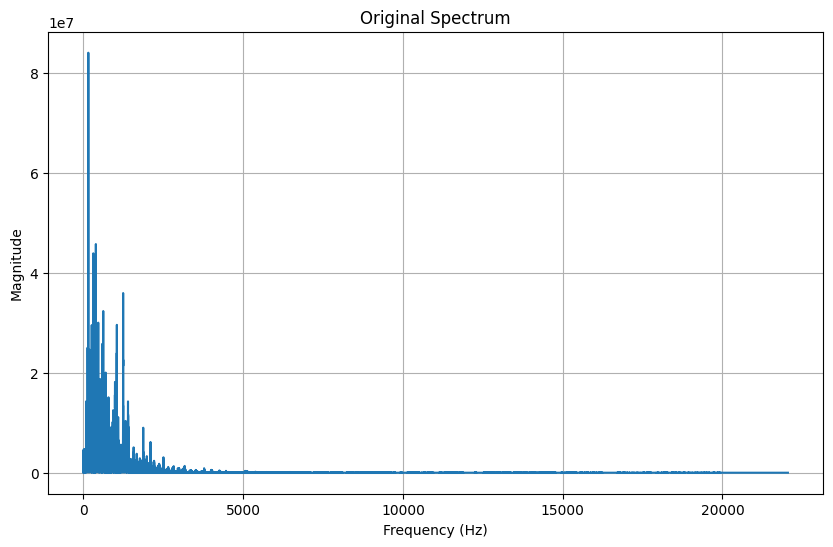

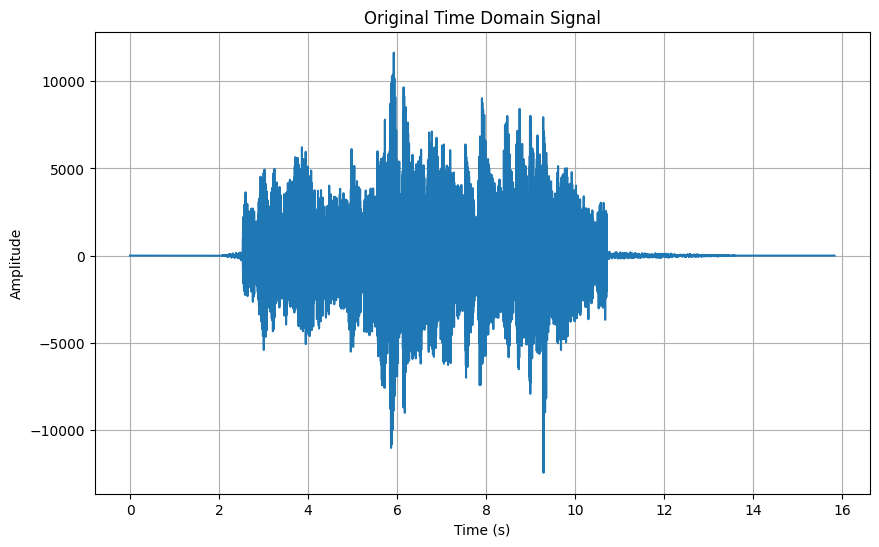

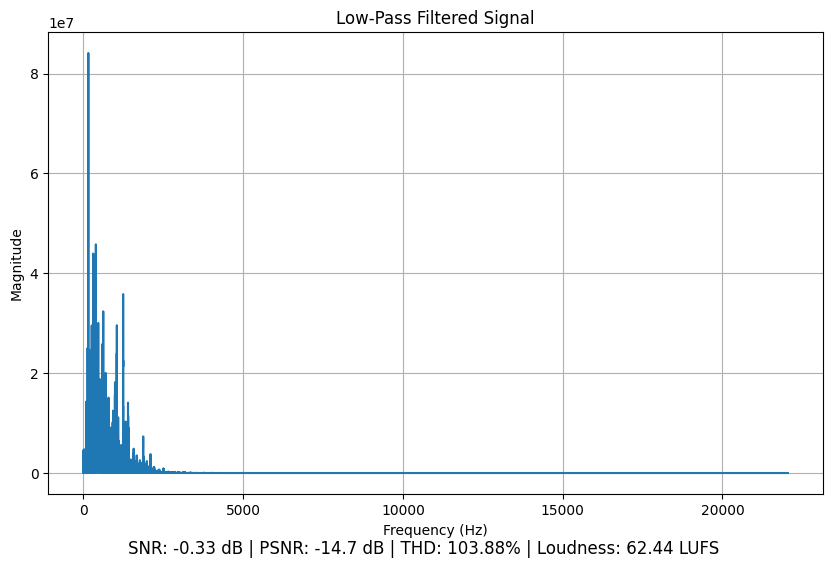

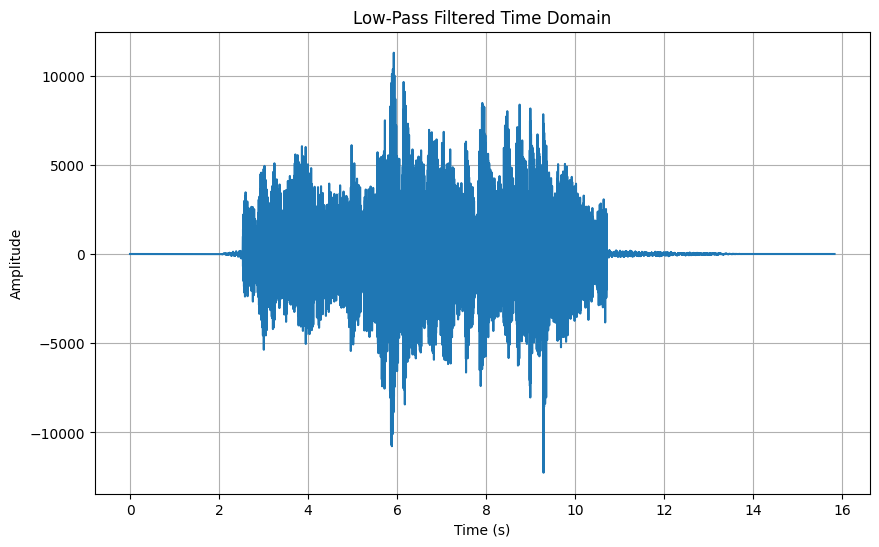

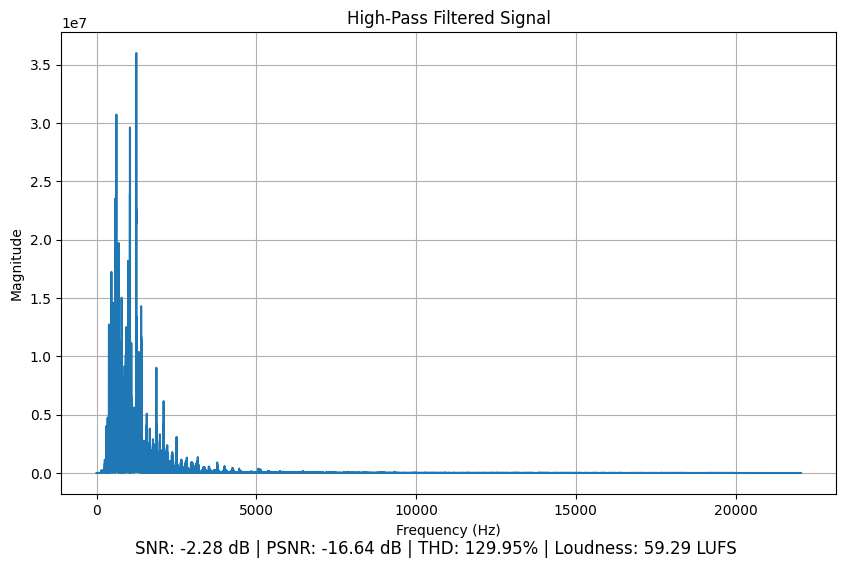

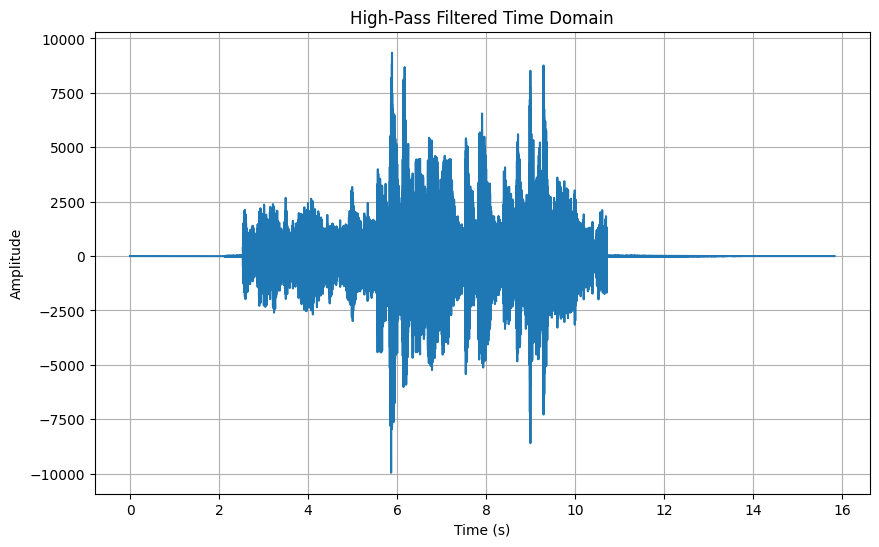

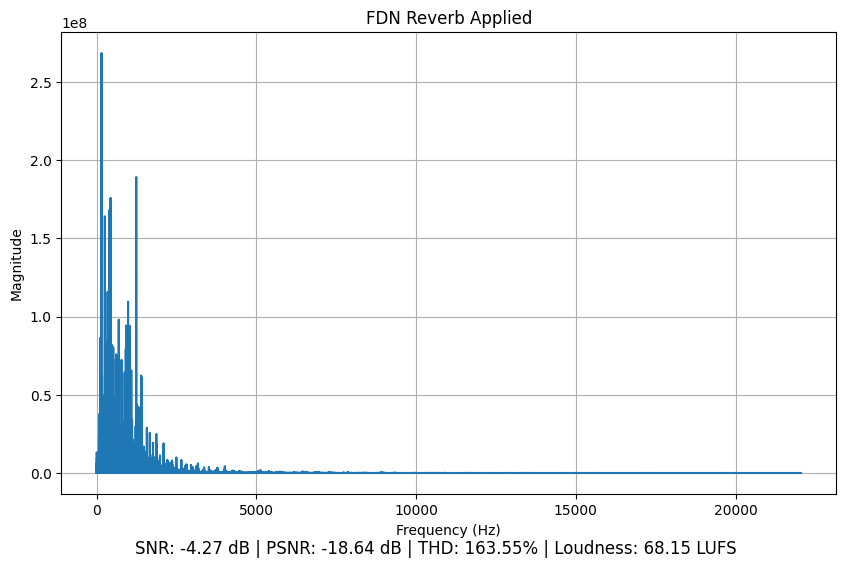

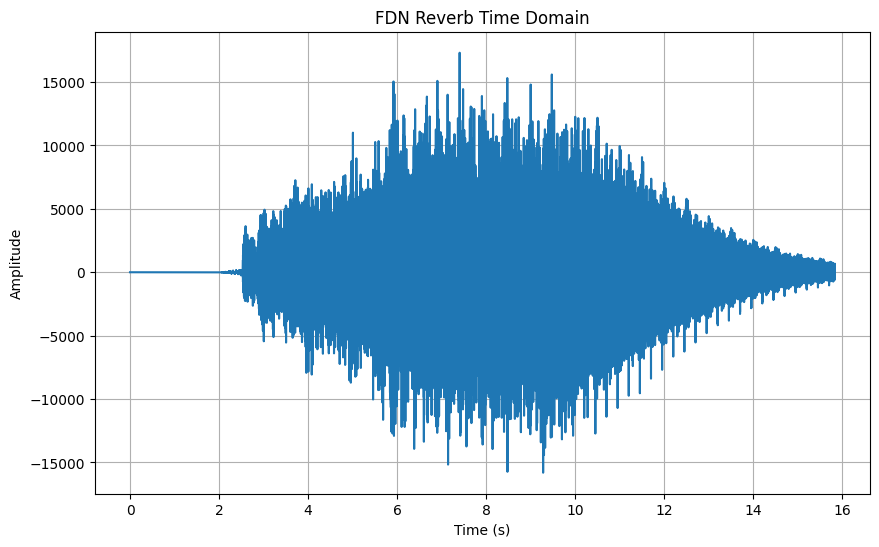

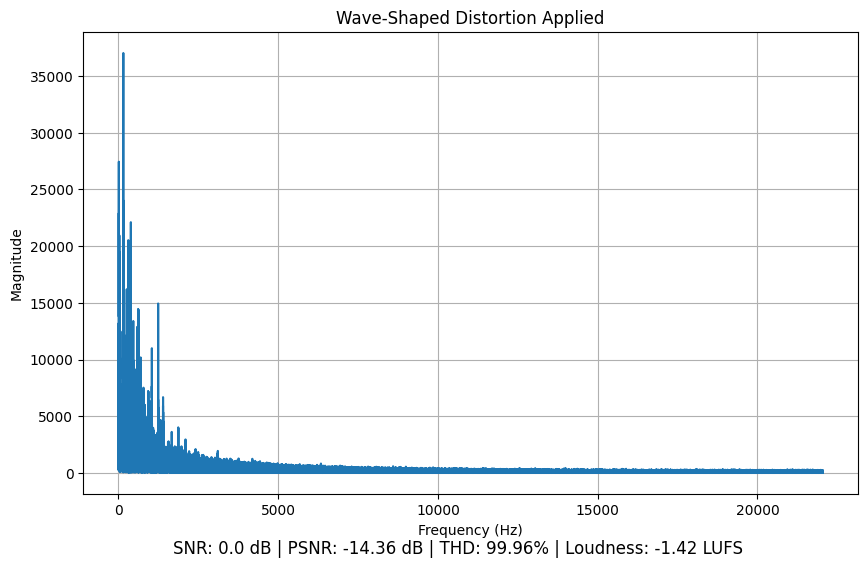

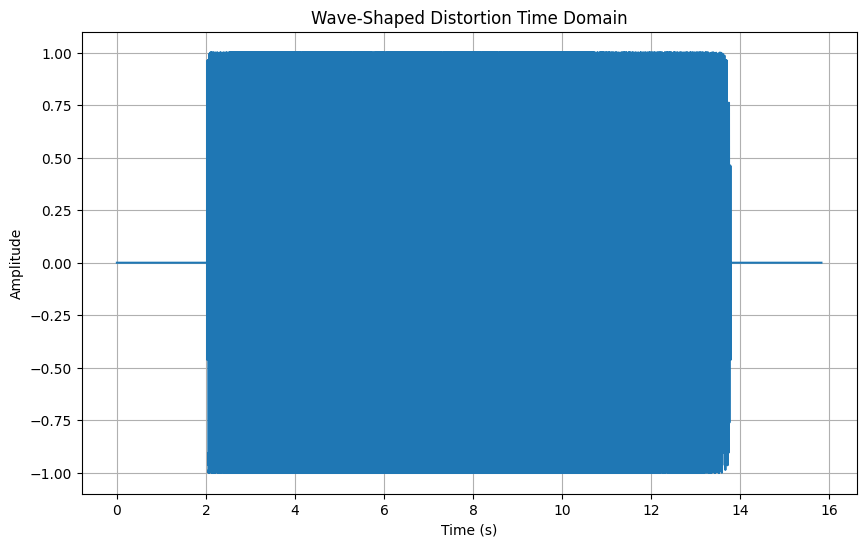

In [ ]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fft
import matplotlib.pyplot as plt
from scipy.io import wavfile
import ipywidgets as widgets
from IPython.display import display, Audio
from ipywidgets import HBox, VBox
import warnings
from scipy.io import wavfile

# Suppress all warnings, including WavFileWarning
warnings.simplefilter("ignore")

# Global variables
samples = None
sample_rate = None
filtered_signal = None  # To hold the filtered signal temporarily

# Plot FFT of the original signal (before any effects)
def plot_original_spectrum(signal, title="Original Spectrum"):
    N = len(signal)
    freqs = np.fft.fftfreq(N, 1/sample_rate)
    fft_values = np.abs(fft.fft(signal))

    plt.figure(figsize=(10, 6))
    plt.plot(freqs[:N//2], fft_values[:N//2])
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()

# Plot time-domain waveform
def plot_time_domain(signal, title="Time Domain Signal"):
    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(0, len(signal) / sample_rate, len(signal)), signal)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

# Load WAV file
def load_audio(file_path):
    global samples, sample_rate
    sample_rate, samples = wavfile.read(file_path)
    samples = samples.astype(np.float32)  # Convert to float for processing
    status_label.value = f"Loaded: {file_path}"

    # Plot the original spectrum and time-domain waveform of the loaded signal
    plot_original_spectrum(samples, "Original Spectrum")
    plot_time_domain(samples, "Original Time Domain Signal")

# Plot FFT
def plot_fft(signal, title):
    N = len(signal)
    freqs = np.fft.fftfreq(N, 1/sample_rate)
    fft_values = np.abs(fft.fft(signal))

    plt.figure(figsize=(10, 6))
    plt.plot(freqs[:N//2], fft_values[:N//2])
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()

    # Show the metrics below the graph
    if filtered_signal is not None:
        snr_value = compute_snr(samples, filtered_signal)
        psnr_value = compute_psnr(samples, filtered_signal)
        thd_value = compute_thd(samples, filtered_signal)
        loudness_value = compute_loudness(filtered_signal)
        plt.figtext(0.5, 0.01, f"SNR: {snr_value} dB | PSNR: {psnr_value} dB | THD: {thd_value}% | Loudness: {loudness_value} LUFS",
                    wrap=True, horizontalalignment='center', fontsize=12)

    plt.show()

# Compute Signal-to-Noise Ratio (SNR)
def compute_snr(original, processed):
    noise = original - processed
    if np.sum(noise ** 2) == 0:  # If noise is zero, return a high SNR value (since signals are identical)
        return float('inf')  # Infinite SNR (no noise)
    snr = 10 * np.log10(np.sum(original ** 2) / np.sum(noise ** 2))
    return round(snr, 2)

# Compute Peak Signal-to-Noise Ratio (PSNR)
def compute_psnr(original, processed):
    mse = np.mean((original - processed) ** 2)
    if mse == 0:
        return 100  # No error
    max_pixel = 255  # Assuming audio is scaled to the range of [0, 255]
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return round(psnr, 2)

# Total Harmonic Distortion (THD)
def compute_thd(original, processed):
    harmonic_distortion = np.sum((processed - original) ** 2)
    fundamental = np.sum(original ** 2)
    thd = np.sqrt(harmonic_distortion / fundamental) * 100
    return round(thd, 2)

# Loudness (in LUFS)
def compute_loudness(signal):
    # Simplified approach: RMS value as a proxy for loudness
    rms = np.sqrt(np.mean(signal ** 2))
    return round(20 * np.log10(rms), 2)

# Feedback Delay Network (FDN) Reverb Effect with Multiple Delay Lines
def apply_fdn_reverb(decay=0.5, delay_samples=[22050, 33075, 44100]):
    global samples, filtered_signal
    if samples is None:
        status_label.value = "Load an audio file first!"
        return

    # FDN approach: Multiple feedback delay lines
    fdn_signal = np.copy(samples)
    delay_buffers = [np.zeros(len(samples)) for _ in delay_samples]

    for i in range(max(delay_samples), len(samples)):
        # Feedback with multiple delay lines
        for j, delay in enumerate(delay_samples):
            fdn_signal[i] += decay * delay_buffers[j][i - delay]
            delay_buffers[j][i] = fdn_signal[i]  # Update delay buffer

    filtered_signal = fdn_signal
    wavfile.write("fdn_reverb.wav", sample_rate, np.int16(filtered_signal))
    plot_fft(filtered_signal, "FDN Reverb Applied")
    plot_time_domain(filtered_signal, "FDN Reverb Time Domain")
    status_label.value = f"Applied FDN Reverb | SNR: {compute_snr(samples, filtered_signal)} dB | PSNR: {compute_psnr(samples, filtered_signal)} dB | THD: {compute_thd(samples, filtered_signal)}% | Loudness: {compute_loudness(filtered_signal)} LUFS"

# Nonlinear Distortion Effect using Wave-Shaping (Soft Clipping)
def apply_wave_shaping_distortion(amount=0.5):
    global samples, filtered_signal
    if samples is None:
        status_label.value = "Load an audio file first!"
        return

    # Apply soft clipping using a wave-shaping function (e.g., tanh function)
    distorted_signal = np.tanh(samples * amount)  # Soft clipping
    filtered_signal = distorted_signal
    wavfile.write("wave_shaped_distortion.wav", sample_rate, np.int16(filtered_signal))
    plot_fft(filtered_signal, "Wave-Shaped Distortion Applied")
    plot_time_domain(filtered_signal, "Wave-Shaped Distortion Time Domain")
    status_label.value = "Applied Wave-Shaped Distortion Effect"

# Low-pass filter
def apply_low_pass(cutoff):
    global samples, filtered_signal
    if samples is None:
        status_label.value = "Load an audio file first!"
        return
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(5, normal_cutoff, btype='low')
    filtered_signal = signal.lfilter(b, a, samples)

    # Calculate SNR, PSNR, THD, and Loudness
    snr_value = compute_snr(samples, filtered_signal)
    psnr_value = compute_psnr(samples, filtered_signal)
    thd_value = compute_thd(samples, filtered_signal)
    loudness_value = compute_loudness(filtered_signal)

    wavfile.write("low_passed.wav", sample_rate, np.int16(filtered_signal))
    plot_fft(filtered_signal, "Low-Pass Filtered Signal")
    plot_time_domain(filtered_signal, "Low-Pass Filtered Time Domain")
    status_label.value = f"Applied Low-Pass Filter | SNR: {snr_value} dB | PSNR: {psnr_value} dB | THD: {thd_value}% | Loudness: {loudness_value} LUFS"

# High-pass filter
def apply_high_pass(cutoff):
    global samples, filtered_signal
    if samples is None:
        status_label.value = "Load an audio file first!"
        return
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(5, normal_cutoff, btype='high')
    filtered_signal = signal.lfilter(b, a, samples)

    # Calculate SNR, PSNR, THD, and Loudness
    snr_value = compute_snr(samples, filtered_signal)
    psnr_value = compute_psnr(samples, filtered_signal)
    thd_value = compute_thd(samples, filtered_signal)
    loudness_value = compute_loudness(filtered_signal)

    wavfile.write("high_passed.wav", sample_rate, np.int16(filtered_signal))
    plot_fft(filtered_signal, "High-Pass Filtered Signal")
    plot_time_domain(filtered_signal, "High-Pass Filtered Time Domain")
    status_label.value = f"Applied High-Pass Filter | SNR: {snr_value} dB | PSNR: {psnr_value} dB | THD: {thd_value}% | Loudness: {loudness_value} LUFS"

# File upload widget
upload_widget = widgets.FileUpload(accept='.wav', multiple=False)

# Button to load and process the audio
def on_upload_change(change):
    file_path = list(upload_widget.value.keys())[0]
    with open(file_path, 'wb') as f:
        f.write(upload_widget.value[file_path]['content'])
    load_audio(file_path)

upload_widget.observe(on_upload_change, names='value')

# Filter control sliders
low_pass_slider = widgets.FloatSlider(value=2000, min=20, max=5000, step=100, description='Low-Pass Cutoff (Hz):')
high_pass_slider = widgets.FloatSlider(value=500, min=20, max=2000, step=100, description='High-Pass Cutoff (Hz):')

# Reverb effect sliders
reverb_slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.05, description='Reverb Amount:')
delay_slider = widgets.IntSlider(value=50, min=10, max=500, step=10, description='Delay (ms):')

# Distortion effect slider
distortion_slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.05, description='Distortion Amount:')

# Button to apply filters
low_pass_button = widgets.Button(description="Apply Low-Pass Filter")
high_pass_button = widgets.Button(description="Apply High-Pass Filter")
play_button = widgets.Button(description="Play Filtered Audio")

# Button to apply reverb
reverb_button = widgets.Button(description="Apply FDN Reverb")

# Button to apply distortion
distortion_button = widgets.Button(description="Apply Distortion Effect")

# Status label (using a Label widget)
status_label = widgets.Label(value="Select an audio file to begin.")

# Connect buttons to functions
def low_pass_button_click(b):
    apply_low_pass(low_pass_slider.value)

def high_pass_button_click(b):
    apply_high_pass(high_pass_slider.value)

def play_button_click(b):
    global filtered_signal
    if filtered_signal is None:
        status_label.value = "No filtered audio to play."
        return

    # Ensure that the filtered signal is properly scaled for audio playback
    max_val = np.max(np.abs(filtered_signal))
    if max_val > 1:
        filtered_signal = filtered_signal / max_val  # Normalize to the range of [-1, 1]

    # Convert to int16 for playback and use IPython's Audio player
    audio_data = np.int16(filtered_signal * 32767)  # Scale to int16 range
    display(Audio(audio_data, rate=sample_rate))  # Display the audio player in the notebook
    status_label.value = "Playing filtered audio."

def reverb_button_click(b):
    apply_fdn_reverb(decay=reverb_slider.value, delay_samples=[22050, 33075, 44100])

def distortion_button_click(b):
    apply_wave_shaping_distortion(amount=distortion_slider.value)

low_pass_button.on_click(low_pass_button_click)
high_pass_button.on_click(high_pass_button_click)
play_button.on_click(play_button_click)
reverb_button.on_click(reverb_button_click)
distortion_button.on_click(distortion_button_click)

# Display widgets in the desired row order
upload_row = HBox([upload_widget])  # Upload Button
low_pass_row = HBox([low_pass_slider, low_pass_button])  # Low-pass filter
high_pass_row = HBox([high_pass_slider, high_pass_button])  # High-pass filter
reverb_row = HBox([reverb_slider, delay_slider, reverb_button])  # Reverb controls
distortion_row = HBox([distortion_slider, distortion_button])  # Distortion controls
play_row = HBox([play_button])  # Play button

# Combine everything into a vertical layout
ui = VBox([upload_row, status_label, low_pass_row, high_pass_row, reverb_row, distortion_row, play_row])

# Display the UI
display(ui)
